In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from nltk.tokenize import word_tokenize
import seaborn as sns
import re
from unidecode import unidecode
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer,PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import os
import json
import joblib

In [2]:
JSON_FILENAME = "Ressources/Recette.json"

def charger_fichier_json(filename):
    if os.path.exists(filename):
        f = open(filename, "r")
        json_data = f.read()
        f.close()
        return json.loads(json_data)
    return None

liste_recettes_sauvegardees = charger_fichier_json(JSON_FILENAME)

dataset = []
for recette in liste_recettes_sauvegardees:
    dataset.append({
            "Nom de la Recette": recette["titre"],
            'Ingredients': "//".join(recette["recette"]["ingredients"]),
            'Puree Preparation': recette["recette"]["infos"]["duree_preparation"],
            'Duree Cuisson': recette["recette"]["infos"]["duree_cuisson"],
            'Duree Repos': recette["recette"]["infos"]["duree_repos"],
            'Etapes de Preparation': "//".join(recette["recette"]["etapes"]),
            "URL Recette": recette["url"],
            "URL_Image": recette["url_image"],
        })

In [3]:
df = pd.DataFrame(dataset)
df.head()

,Nom de la Recette,Ingredients,Puree Preparation,Duree Cuisson,Duree Repos,Etapes de Preparation,URL Recette,URL_Image
0,"Joulutorttu, étoiles de Noël finlandaises",200 g de farine semi-complète//1 c. café de bi...,30 min,15 min,,"La veille, préparer la pâte feuilletée : mélan...",https://www.cuisine-libre.org/joulutorttu-etoi...,https://www.cuisine-libre.org/local/cache-gd2/...
1,Gâteau de l’amitié Herman,1 part de levain Herman [*]//2 tasses (300 g) ...,20 min,40 min,10 j,Herman est vivant. Vous devez le garder en vie...,https://www.cuisine-libre.org/gateau-amitie-he...,https://www.cuisine-libre.org/local/cache-gd2/...
2,Cookies au chocolat et à la farine de châtaigne,120 g de sucre//50 g de beurre mou//1 œuf//80 ...,15 min,20 min,1 h,"Dans un saladier, mélanger le beurre mou et le...",https://www.cuisine-libre.org/cookies-au-choco...,https://www.cuisine-libre.org/local/cache-gd2/...
3,Sablés à la cannelle,220 g de Farine//70 g de poudre d’amandes//100...,20 min,10 min,30 min,Sortir le beurre du réfrigérateur.//Préchauffe...,https://www.cuisine-libre.org/sables-a-la-cann...,https://www.cuisine-libre.org/local/cache-gd2/...
4,Gâteau irlandais de la Toussaint,220 g de farine//15 g de levure de boulanger//...,20 min,50 min,,Préchauffez le four à 180°C.//Émiettez la levu...,https://www.cuisine-libre.org/gateau-irlandais...,https://www.cuisine-libre.org/local/cache-gd2/...


In [4]:
df.to_excel('Ressources/Recettes.xlsx', index=False)

In [5]:
stop_words = list(set(stopwords.words('french')))
lemmatizer = WordNetLemmatizer()
ps = PorterStemmer()

In [6]:
new_stopwords =["tout","ramolli","rapide","extrait","soude","usage","cuillere",
                "petite","belle","commencer","melange","heure","recette", "surgelé",
                "avant","rouge","sortir","kg","g","si","dénoyaute ",
                "pincée","ça","ou","fondu","mou","soupe","coulis",
                "bombée","pot","litre","peu","froid","non","fin","c.","gros","sans","grosse","en","a","etc"]

stop_words.extend(new_stopwords)

In [7]:
def Pretraitement(text, param = 1):
    
    def remove_s(word):
        if word.endswith('s'):
            return word[:-1]
        else:
            return word
        
    #listes = 
    liste1 = ["cc "," oise ","/ ","cac","cl ","ml "]
        
    # Supprimer des ponctuations
    text = re.sub("[^\w\s]", " ", text)
    
    if param == 1:
        text = ' '.join([lemmatizer.lemmatize(word.lower()) for word in word_tokenize(text) if word.isalnum() and word.lower() not in stop_words])
    else:
        text = ' '.join([ps.stem(unidecode(word.lower())) for word in word_tokenize(text) if word.isalnum() and word.lower() not in stop_words])
       
    # supprimer les chiffres
    text = re.sub("\d", "", text)
    
    for i in liste1:
        text = text.replace(i," ")
    
    #text = [remove_s(word) for word in text]
    
    text = text.replace("ee","e")
    
    text = list(set(text.split()))
    
    text = ' '.join([remove_s(word) for word in text])
    
    return text

In [8]:
df["Ingredient_lem_token"] = df["Ingredients"].apply(lambda x: Pretraitement(x))
df["Ingredient_lem_token"]

0      levure sucre œuf glace farine café fromage chi...
1      raisin ½ neutre sucre tasse farine café ⅔ part...
2      coupé morceau farine châtaigne levure flocon s...
3      farine cannelle café levure sachet poudre sel ...
4      raisin brun levure smyrne muscade sucre œuf fa...
                             ...                        
265    farine levure lait œuf muscade chimique paquet...
266    biscuit ao madeira fondant œuf boîte sucre beu...
267    farine traité yaourt nature pot levure ½ neutr...
268    déshydratée farine boulanger levure lait œuf s...
269    parfum raisin pain sec lait rassi oranger œuf ...
Name: Ingredient_lem_token, Length: 270, dtype: object

In [9]:
df.head()

,Nom de la Recette,Ingredients,Puree Preparation,Duree Cuisson,Duree Repos,Etapes de Preparation,URL Recette,URL_Image,Ingredient_lem_token
0,"Joulutorttu, étoiles de Noël finlandaises",200 g de farine semi-complète//1 c. café de bi...,30 min,15 min,,"La veille, préparer la pâte feuilletée : mélan...",https://www.cuisine-libre.org/joulutorttu-etoi...,https://www.cuisine-libre.org/local/cache-gd2/...,levure sucre œuf glace farine café fromage chi...
1,Gâteau de l’amitié Herman,1 part de levain Herman [*]//2 tasses (300 g) ...,20 min,40 min,10 j,Herman est vivant. Vous devez le garder en vie...,https://www.cuisine-libre.org/gateau-amitie-he...,https://www.cuisine-libre.org/local/cache-gd2/...,raisin ½ neutre sucre tasse farine café ⅔ part...
2,Cookies au chocolat et à la farine de châtaigne,120 g de sucre//50 g de beurre mou//1 œuf//80 ...,15 min,20 min,1 h,"Dans un saladier, mélanger le beurre mou et le...",https://www.cuisine-libre.org/cookies-au-choco...,https://www.cuisine-libre.org/local/cache-gd2/...,coupé morceau farine châtaigne levure flocon s...
3,Sablés à la cannelle,220 g de Farine//70 g de poudre d’amandes//100...,20 min,10 min,30 min,Sortir le beurre du réfrigérateur.//Préchauffe...,https://www.cuisine-libre.org/sables-a-la-cann...,https://www.cuisine-libre.org/local/cache-gd2/...,farine cannelle café levure sachet poudre sel ...
4,Gâteau irlandais de la Toussaint,220 g de farine//15 g de levure de boulanger//...,20 min,50 min,,Préchauffez le four à 180°C.//Émiettez la levu...,https://www.cuisine-libre.org/gateau-irlandais...,https://www.cuisine-libre.org/local/cache-gd2/...,raisin brun levure smyrne muscade sucre œuf fa...


## VECTORISATION

In [10]:
tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix = tfidf_vectorizer.fit_transform(df["Ingredient_lem_token"]).toarray()
print(tfidf_matrix.shape)

(270, 688)


In [11]:
feature_names = tfidf_vectorizer.get_feature_names_out()
len(feature_names)

688

In [12]:
df1 = pd.DataFrame(tfidf_matrix,columns=feature_names)
df1.head()

,abricot,acidulée,active,affaire,agave,agen,ahuète,alcool,alimentaire,allergique,...,équitable,équivalent,érable,étaler,étalée,étoilé,éventuellement,éviter,ôter,œuf
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.078720
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.071577
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.103561
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.082165


In [13]:
df_tif = pd.DataFrame(df1.sum(), columns=["Values"])

In [14]:
df_tif = df_tif.sort_values("Values",ascending=False)
df_tif_30 = df_tif.head(30)
df_tif_30.head()

,Values
œuf,22.140818
sucre,21.825805
farine,21.345952
beurre,21.015194
levure,17.453220


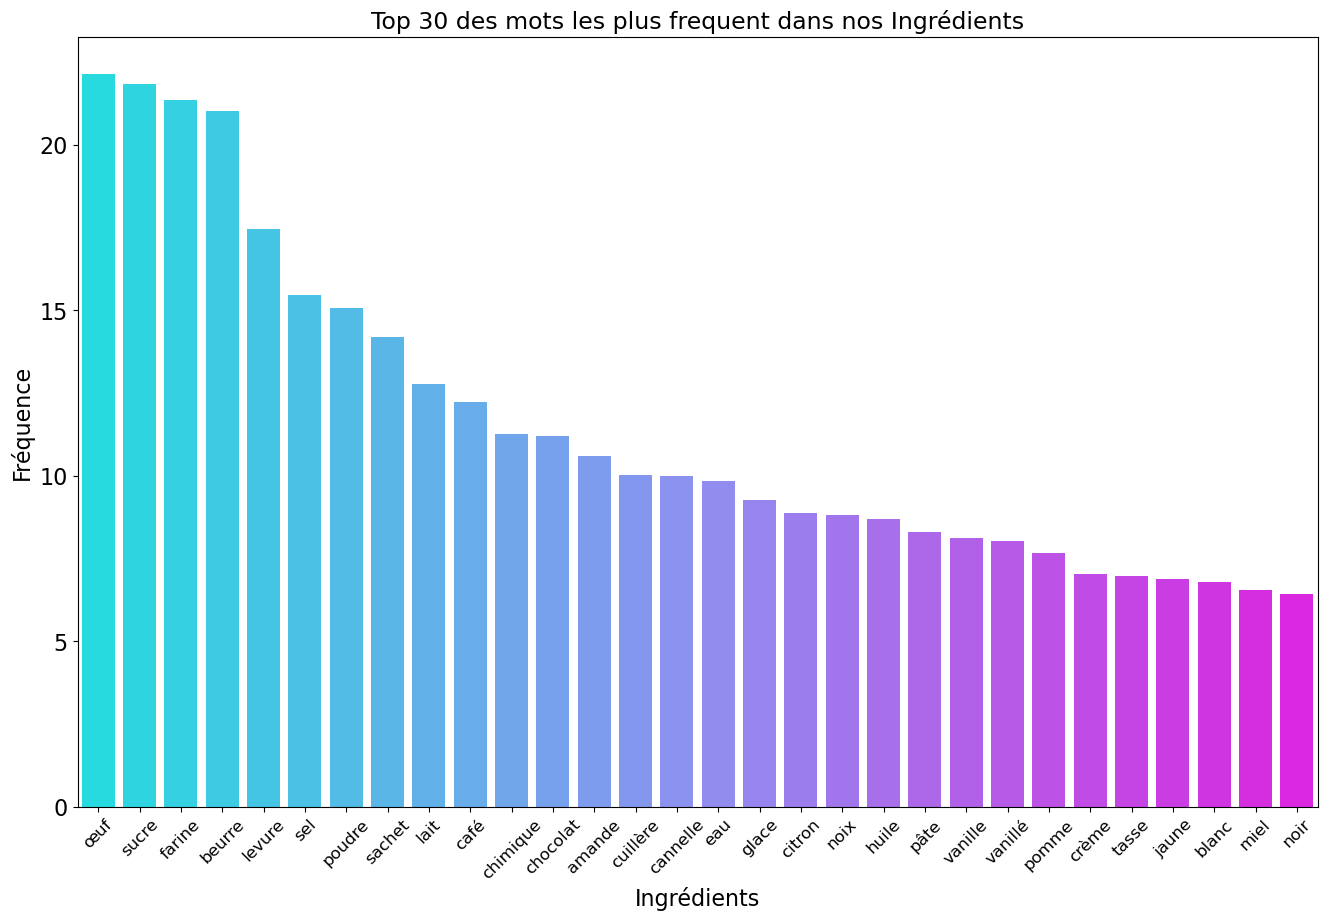

In [15]:
# affichons les 30 mots les plus present dans nos Symptomes
fig = plt.figure(figsize = (16, 10))

g = sns.barplot(
    x = df_tif_30.index,
    y = df_tif_30["Values"],
    data = df_tif_30,
    palette = 'cool'
)

g.set_xticklabels(
    g.get_xticklabels(),
    rotation = 45,
    fontsize = 12
)

plt.yticks(fontsize=16)
plt.xlabel('Ingrédients', fontsize = 16)
plt.ylabel('Fréquence', fontsize = 16)
plt.title("Top 30 des mots les plus frequent dans nos Ingrédients", fontsize = 17)
# Exporter le graphique en tant qu'image pnj
plt.savefig('Diagrammes/Top 30 des ingrédients les plus frequent.png', dpi=500);
plt.show()

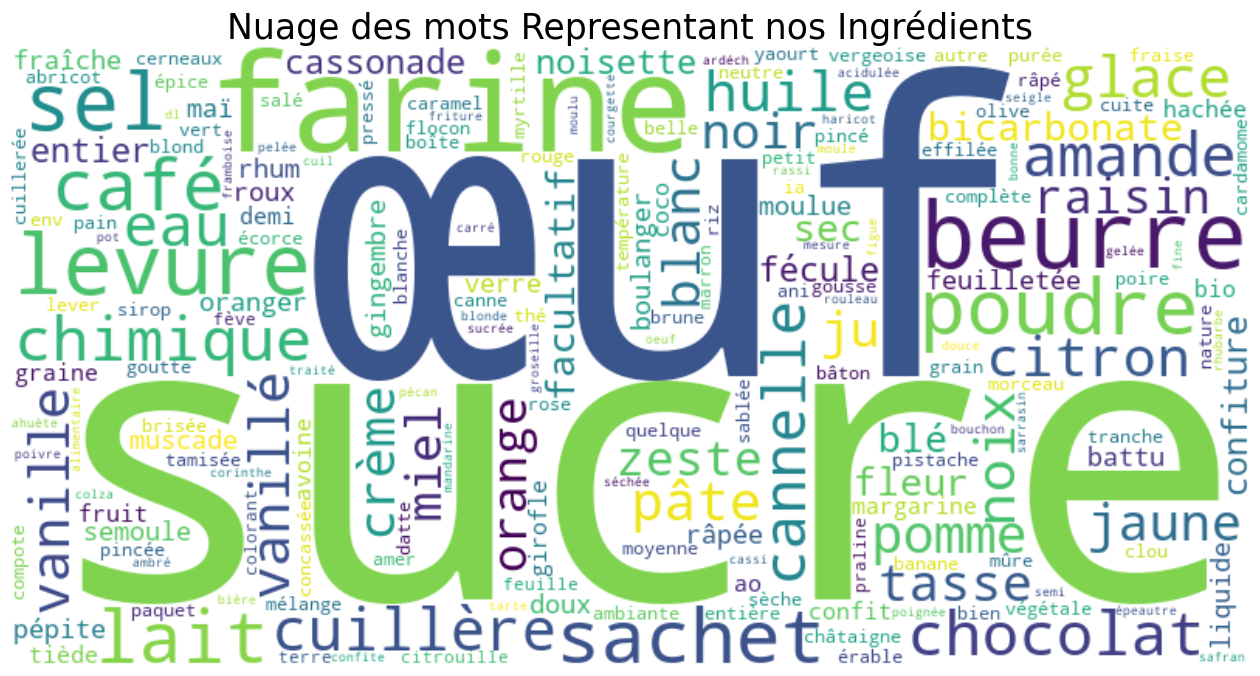

In [16]:
# Création d'un dictionnaire à partir du DataFrame
dictionnaire_mots_poids = dict(zip(df_tif.index,df_tif["Values"]))

# Création de l'objet WordCloud avec generate_from_frequencies
wordcloud = WordCloud(width=800, height=400, background_color='white')
wordcloud.generate_from_frequencies(dictionnaire_mots_poids)

# Affichage du WordCloud à l'aide de matplotlib
plt.figure(figsize=(16, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Supprimer les axes
plt.title('Nuage des mots Representant nos Ingrédients', fontsize = 25)
# Exporter le graphique en tant qu'image pnj
plt.savefig('Diagrammes/Nuage des mots Representant nos Ingrédients.png', dpi=500);
plt.show()

## Calcul de similarité

In [17]:
# Requête de recherche
query = '250 g de farine,1 œuf//125 g de beurre//125 g de tout goiuyt roux//50 g à 100 g de chocolat'

# Prétraitement de la requête
query = Pretraitement(query, param = 0)

In [18]:
df["Ingredient_stem_token"] = df["Ingredients"].apply(lambda x: Pretraitement(x, param = 0))
df["Ingredient_stem_token"]

0      levur epais cafe creme sucr jaun glace ju chim...
1      raisin coupe sucr cafe cuir pomm tas morceaux ...
2      flocon ardech avoin beurr morceaux farin sucr ...
3      amand cannel beurr poudr farin sucr sachet caf...
4      raisin corinth tied brun levur sucr confit bou...
                             ...                        
265    paquet beurr chimiqu muscad tas farin lait suc...
266    biscuit ao beurr madeira boit sucr chocolat fo...
267    amand natur neutr poudr pot yaourt farin oeuf ...
268    deshydrate beurr tied bicarbon farin lait levu...
269    parfum raisin sec rassi beurr lait fruit sucr ...
Name: Ingredient_stem_token, Length: 270, dtype: object

In [19]:
df.head()

,Nom de la Recette,Ingredients,Puree Preparation,Duree Cuisson,Duree Repos,Etapes de Preparation,URL Recette,URL_Image,Ingredient_lem_token,Ingredient_stem_token
0,"Joulutorttu, étoiles de Noël finlandaises",200 g de farine semi-complète//1 c. café de bi...,30 min,15 min,,"La veille, préparer la pâte feuilletée : mélan...",https://www.cuisine-libre.org/joulutorttu-etoi...,https://www.cuisine-libre.org/local/cache-gd2/...,levure sucre œuf glace farine café fromage chi...,levur epais cafe creme sucr jaun glace ju chim...
1,Gâteau de l’amitié Herman,1 part de levain Herman [*]//2 tasses (300 g) ...,20 min,40 min,10 j,Herman est vivant. Vous devez le garder en vie...,https://www.cuisine-libre.org/gateau-amitie-he...,https://www.cuisine-libre.org/local/cache-gd2/...,raisin ½ neutre sucre tasse farine café ⅔ part...,raisin coupe sucr cafe cuir pomm tas morceaux ...
2,Cookies au chocolat et à la farine de châtaigne,120 g de sucre//50 g de beurre mou//1 œuf//80 ...,15 min,20 min,1 h,"Dans un saladier, mélanger le beurre mou et le...",https://www.cuisine-libre.org/cookies-au-choco...,https://www.cuisine-libre.org/local/cache-gd2/...,coupé morceau farine châtaigne levure flocon s...,flocon ardech avoin beurr morceaux farin sucr ...
3,Sablés à la cannelle,220 g de Farine//70 g de poudre d’amandes//100...,20 min,10 min,30 min,Sortir le beurre du réfrigérateur.//Préchauffe...,https://www.cuisine-libre.org/sables-a-la-cann...,https://www.cuisine-libre.org/local/cache-gd2/...,farine cannelle café levure sachet poudre sel ...,amand cannel beurr poudr farin sucr sachet caf...
4,Gâteau irlandais de la Toussaint,220 g de farine//15 g de levure de boulanger//...,20 min,50 min,,Préchauffez le four à 180°C.//Émiettez la levu...,https://www.cuisine-libre.org/gateau-irlandais...,https://www.cuisine-libre.org/local/cache-gd2/...,raisin brun levure smyrne muscade sucre œuf fa...,raisin corinth tied brun levur sucr confit bou...


In [20]:
df.to_excel('Ressources/Recettes_token.xlsx', index=False)
df.to_csv('Ressources/Recettes_token.csv', index=False)
df.to_json('Ressources/Recettes_token.json')

In [21]:
tif2 = TfidfVectorizer()

cosine_similarite = []
feature_names = []

for i in range(len(df["Ingredient_stem_token"])):
    tfidf2 = tif2.fit_transform([df['Ingredient_stem_token'][i]]).toarray()
    cosine_similaritie = cosine_similarity(tfidf2, tif2.transform([query]))[0]
    cosine_similarite.append(cosine_similaritie)
    feature_name = tif2.get_feature_names_out()
    feature_names.extend(feature_name)
    
len(feature_names)

4232

In [22]:
cosine_similaritie = np.array(cosine_similarite)

In [23]:
df['Similarite_%'] = 100*cosine_similaritie.flatten()

In [24]:
df['Similarite_%']

0      37.796447
1      36.927447
2      53.452248
3      44.721360
4      38.729833
         ...    
265    52.223297
266    57.735027
267    34.299717
268    50.000000
269    39.223227
Name: Similarite_%, Length: 270, dtype: float64

In [25]:
df_tri = df.sort_values(by='Similarite_%', ascending=False)

In [26]:
print(query)
df_tri[:20]

goiuyt roux beurr farin chocolat oeuf


,Nom de la Recette,Ingredients,Puree Preparation,Duree Cuisson,Duree Repos,Etapes de Preparation,URL Recette,URL_Image,Ingredient_lem_token,Ingredient_stem_token,Similarite_%
119,Cookies rapides au chocolat,250 g de farine//1 œuf//125 g de beurre//125 g...,15 min,7 min,,Préchauffer le four à 210°C.//Tailler des pépi...,https://www.cuisine-libre.org/cookies-rapides-...,https://www.cuisine-libre.org/local/cache-gd2/...,farine roux sucre beurre chocolat œuf,roux beurr farin sucr chocolat oeuf,91.287093
108,Mi-cuit au chocolat,250 g de chocolat//100 g de beurre//3 œufs//2 ...,10 min,15 min,,"Dans un saladier, faire mousser les œufs et le...",https://www.cuisine-libre.org/mi-cuit-au-chocolat,https://www.cuisine-libre.org/local/cache-gd2/...,farine cuillère œuf sucre beurre chocolat,beurr farin sucr chocolat cuiller oeuf,81.649658
102,Fondant au chocolat,250 g de beurre//250 g de sucre//250 g de choc...,10 min,2 h,30 min,Faire fondre dans une casserole le chocolat et...,https://www.cuisine-libre.org/fondant-au-chocolat,https://www.cuisine-libre.org/local/cache-gd2/...,farine cuillère œuf sucre beurre chocolat,beurr farin sucr chocolat cuiller oeuf,81.649658
241,Mini gâteau au chocolat fondant,200 g de chocolat noir//90 g de beurre//90 g d...,10 min,7 min,,Préchauffez votre four à 170°C.//Faites fondre...,https://www.cuisine-libre.org/mon-mini-gateau-...,https://www.cuisine-libre.org/local/cache-gd2/...,noir farine roux œuf sucre beurre chocolat pra...,noir roux beurr oeuf farin sucr chocolat pralin,79.056942
246,Biscuits sablés,250 g de farine//125 g de beurre ramolli//125 ...,20 min,10 min,1 h,Préchauffer le four à 180°C.//Blanchir le beur...,https://www.cuisine-libre.org/biscuits-sables,https://www.cuisine-libre.org/local/cache-gd2/...,farine entier sucre beurre œuf,beurr farin sucr entier oeuf,77.459667
137,Biscuit au miel d’Ostara,100 g de miel//100 g de farine//50 g de beurre...,15 min,45 min,,Préchauffer le four à 150°C/300°F.//Beurrer un...,https://www.cuisine-libre.org/biscuit-au-miel-...,https://www.cuisine-libre.org/local/cache-gd2/...,farine levure sachet ⅔ œuf beurre miel,beurr farin sachet levur oeuf miel,70.710678
126,Tarte aux pommes et compote,100 g de beurre fondu//80 g de sucre//1 pincée...,20 min,45 min,30 min,"Mélanger le beurre fondu, le sucre et le sel./...",https://www.cuisine-libre.org/tarte-aux-pommes...,https://www.cuisine-libre.org/local/cache-gd2/...,farine vanille cannelle pomme sel sucre beurre...,cannel pomm beurr farin sucr sel vanil oeuf,61.237244
100,Lammele,4 œufs//120 g de sucre//120 g de farine//20 g ...,30 min,30 min,30 min,Préchauffer le four à 180°C.//À l’aide d’un pi...,https://www.cuisine-libre.org/lammele,https://www.cuisine-libre.org/local/cache-gd2/...,glace farine vanille œuf sucre beurre fécule g...,glace fecul gous beurr farin sucr vanil oeuf,61.237244
192,Moelleux au chocolat,150 g de chocolat noir//80 g de beurre//100 g ...,15 min,30 min,,Faire fondre le beurre et le chocolat cassé en...,https://www.cuisine-libre.org/moelleux-au-choc...,https://www.cuisine-libre.org/local/cache-gd2/...,noir maï cuillère œuf sucre beurre chocolat fé...,noir fecul beurr oeuf sucr mai cuiller chocolat,61.237244
11,Cookies inratables aux pépites de chocolat,150 g de beurre//100 g de cassonade//80 g de s...,20 min,12 min,1 h,"La cuisson effectuée, laissez refroidir vos co...",https://www.cuisine-libre.org/cookies-inratabl...,https://www.cuisine-libre.org/local/cache-gd2/...,cassonade farine pépite déco blanc chocolat se...,beurr deco cassonad pepit bicarbon blanc farin...,60.302269
